In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from numpy import zeros_like
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import scipy.stats as ss

sympy.init_printing()

from Pricer import Pricer
from Processes import Processes

from scipy.stats.qmc import Sobol
from scipy.stats import norm

In [3]:
basis = 'leguerre'

# parameters

mu = 0.06
r = 0.06
sigma = 0.04
T = 1
I = 250
paths = 1000
S0 = 37
S0_list = range(37, 43, 1)
m = 0
K = 40
deg = 3
df = np.exp(-r * T/I)

GBM_sigma = sigma
GBM_mu = r

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

LNparams = (LN_lam, LN_sigma, LN_mu, LN_v, m)
JRparams = (JR_lam, JR_sigma, JR_mu)
GBMparams = (GBM_mu, GBM_sigma)

# instance
processes = Processes(S0, r, T, K, paths, I, LNparams, JRparams, GBMparams)
pricer = Pricer(S0, r, sigma, T, K, paths, I, LNparams, JRparams, GBMparams)

Processes class created with S0 = 37, paths = 1000, I = 250, T = 1


In [4]:
GBM_paths = processes.gbm_paths()

In [5]:
import numpy as np

def update_exercise_matrix(exercise_matrix):
    for path in range(exercise_matrix.shape[0]):
        first_exercise = np.where(exercise_matrix[path])[0]
        if first_exercise.size > 0:
            # Set all values after the first exercise to False
            exercise_matrix[path, first_exercise[0] + 1:] = False
    return exercise_matrix

def LSM(K, S, I, df, basis, deg):
    paths = len(S)
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1]  # set value at maturity equal to intrinsic value
    exercise_matrix = np.zeros_like(H, dtype=bool)  # matrix to track exercise decisions

    # Valuation by LS Method
    for t in range(I - 2, 0, -1):
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive

        if np.sum(good_paths) > 0:
            # Fit the continuation value based on the chosen basis
            if basis == 'poly':
                rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polyval(rg, S[good_paths, t])
            elif basis == 'legendre':
                rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.legendre.legval(S[good_paths, t], rg)
            elif basis == 'laguerre':
                rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
            else:  # 'hermite'
                rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.hermite.hermval(S[good_paths, t], rg)

            exercise = H[good_paths, t] > C
            exercise_full = np.zeros_like(H[:, t], dtype=bool)
            exercise_full[good_paths] = exercise
        else:
            exercise_full = np.zeros_like(H[:, t], dtype=bool)

        exercise_matrix[:, t] = exercise_full
        V[exercise_full, t] = H[exercise_full, t]
        V[exercise_full, t + 1:] = 0
        discount_path = ~exercise_full
        V[discount_path, t] = V[discount_path, t + 1] * df

    exercise_matrix = update_exercise_matrix(exercise_matrix)

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    V0_array = V[:, 1] * df
    SE = np.std(V[:, 1] * df) / np.sqrt(paths)
    return V0, V0_array, SE, exercise_matrix, V


In [28]:
V0, V0_array, SE, exercise_matrix_G, V = LSM(K, GBM_paths, I, df, basis, deg)

In [7]:
def black_scholes_put(S, K, T, t, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    put_price = K * np.exp(-r * (T - t)) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

In [8]:
# Initialize a matrix to store the discounted European put prices
european_put_prices = np.zeros_like(exercise_matrix, dtype=float)

for path in range(exercise_matrix.shape[0]):
    for time in range(exercise_matrix.shape[1]):
        if exercise_matrix[path, time]:
            S_at_exercise = GBM_paths[path, time]
            t = time * (T / I)  # Current time in years
            undiscounted_price = pricer.closed_formula_GBM(S_at_exercise, K, T-t, r, sigma)
            discount_factor = np.exp(-r * t)  # Discount factor back to time 0
            european_put_prices[path, time] = undiscounted_price * discount_factor

first_exercise_prices = np.zeros(european_put_prices.shape[0])

for path in range(european_put_prices.shape[0]):
    # Find the first non-zero price for this path
    first_exercise_price = next((price for price in european_put_prices[path, :] if price > 0), 0)
    first_exercise_prices[path] = first_exercise_price

crude_monte_carlo_european_GBM = pricer.crude_monte_carlo_european(GBM_paths)

cov = np.cov(crude_monte_carlo_european_GBM, V0_array)

alpha = -cov[0, 1] / cov[0, 0]

adjusted_payoff = V0 + alpha * (crude_monte_carlo_european_GBM - np.mean(first_exercise_prices))

In [9]:
print("The average price of the european is: ", np.mean(first_exercise_prices))
print("The average price of the american is: ", V0)

print("The standard error of the european is: ", np.std(first_exercise_prices) / np.sqrt(paths))
print("The standard error of the american is: ", SE)


The average price of the european is:  0.9908737195027993
The average price of the american is:  2.9916662804532326
The standard error of the european is:  0.001911489333601862
The standard error of the american is:  0.0028657001450516795


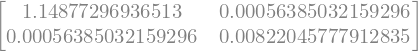

In [10]:
display_matrix(cov)

In [11]:
print("The covariance between the european and the american is: ", cov[0, 1])

The covariance between the european and the american is:  0.0005638503215929601


In [12]:
print("The optimal hedge ratio is: ", alpha)

The optimal hedge ratio is:  -0.0004908283330383133


In [13]:
print("The adjusted payoff is: ", np.mean(adjusted_payoff))
print("the payoff of the american is: ", V0)

The adjusted payoff is:  2.991637117643991
the payoff of the american is:  2.9916662804532326


In [14]:
print("The standard error of the adjusted payoff is: ", np.std(adjusted_payoff) / np.sqrt(paths))
print("The standard error of the american is: ", SE)

The standard error of the adjusted payoff is:  1.6627596330113346e-05
The standard error of the american is:  0.0028657001450516795
